# The Dataset for Pretraining Word Embedding

In [1]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l
from ptb_dataset import PTBDataset, batchify

The dataset that we use here is Penn Tree Bank (PTB). This corpus is sampled from Wall Street Journal articles, split into training, validation, and test sets. In the original format, each line of the text file represents a sentence of words that are separated by spaces. Here we treat each word as a token.

## Reading the Dataset

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

After reading the training set, we build a vocabulary for the corpus, where any word that appears less than 10 times is replaced by the “<unk>” token. Note that the original dataset also contains “<unk>” tokens that represent rare (unknown) words.

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## Subsampling

In [4]:
#@save
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

The following code snippet plots the histogram of the number of tokens per sentence before and after subsampling. As expected, subsampling significantly shortens sentences by dropping high-frequency words, which will lead to training speedup.

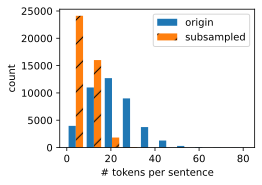

In [5]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

For individual tokens, the sampling rate of the high-frequency word “the” is less than 1/20.

In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2075'

In contrast, low-frequency words “join” are completely kept.

In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

After subsampling, we map tokens to their indices for the corpus.

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6612, 3228, 416], [993, 3922, 1922, 4743]]

## Extracting Center Words and Context Words

The following get_centers_and_contexts function extracts all the center words and their context words from corpus. It uniformly samples an integer between 1 and max_window_size at random as the context window size. For any center word, those words whose distance from it does not exceed the sampled context window size are its context words.

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Next, we create an artificial dataset containing two sentences of 7 and 3 words, respectively. Let the maximum context window size be 2 and print all the center words and their context words.

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


When training on the PTB dataset, we set the maximum context window size to 5. The following extracts all the center words and their context words in the dataset.

In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1502118'

## Negative Sampling

We use negative sampling for approximate training. To sample noise words according to a predefined distribution, we define the following RandomGenerator class, where the (possibly unnormalized) sampling distribution is passed via the argument sampling_weights.

In [12]:
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [13]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]


[1, 1, 3, 3, 3, 1, 3, 1, 2, 3]

In [14]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## Loading Training Examples in Minibatches

In [15]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## Putting it all together

In [16]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [17]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# Pretraining

In [18]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## The Skip-Gram Model
### Embedding Layer

In [20]:
from torch import nn
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [21]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.0548,  1.1806, -0.5769,  2.0738],
         [-1.1683,  0.2458, -0.6266, -1.1380],
         [-1.3675, -0.7355,  0.4003, -0.8929]],

        [[-1.0180, -1.1501, -0.5824,  0.2831],
         [ 0.0509, -0.5943,  0.3595,  1.2877],
         [-1.6050, -0.6054, -0.9210,  0.1402]]], grad_fn=<EmbeddingBackward0>)

### Defining the Forward Propagation

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [23]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## Training 
### Binary Cross-Entropy Loss

In [24]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [25]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

### Initializing Model Parameters

In [26]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### Defining the Training Loop

In [27]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now we can train a skip-gram model using negative sampling.

loss 0.410, 54692.6 tokens/sec on cpu


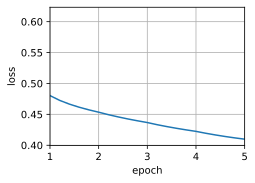

In [28]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## Applying Word Embeddings

In [29]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.697: intel
cosine sim=0.671: processes
cosine sim=0.650: microprocessor


In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('today', 3, net[0])

cosine sim=0.524: morning
cosine sim=0.495: p.m.
cosine sim=0.489: broadcast


In [36]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('apple', 3, net[0])

cosine sim=0.590: dell
cosine sim=0.548: hardware
cosine sim=0.528: kellogg


In [37]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('red', 3, net[0])

cosine sim=0.607: cross
cosine sim=0.547: leather
cosine sim=0.510: recorders


In [38]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('ball', 3, net[0])

cosine sim=0.623: mentioned
cosine sim=0.618: anne
cosine sim=0.609: thieves
